# LIF Ensemble

## Import dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sapinet.ensemble.spiking import LIFEnsemble
from sapinet.analysis.utils.plotting import spike_raster 

In [3]:
# Uncomment the following line if sapinet is not already installed in your current environment
# %pip install git+https://github.com/cplab/sapinet2.git

## Define experiment specific variables

In [4]:
steps = 200

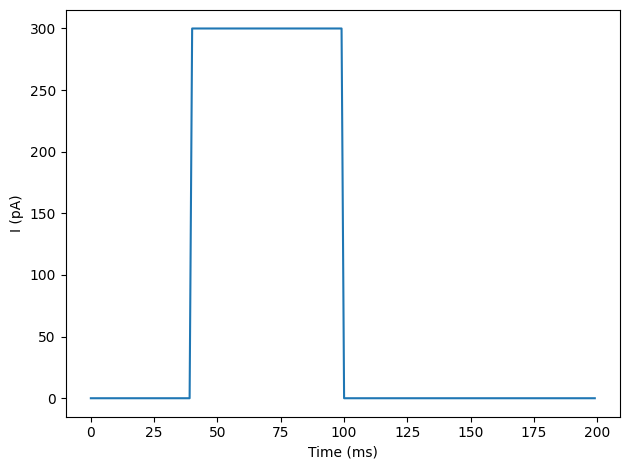

In [5]:
I = torch.ones(steps) * 300
I[int(steps/2):] = 0
I[:int(steps/5)] = 0

plt.subplots(1)
plt.plot(range(steps), I)
plt.xlabel('Time (ms)')
plt.ylabel('I (pA)')
plt.tight_layout()
plt.show()

## Let's create an ensemble of 10 neurons

In [6]:
spiking_ensemble = LIFEnsemble(10)

In [7]:
output = [spiking_ensemble.forward(I[i]) for i in range(steps)]
print(output[0])

{'volt_mem': tensor([-75., -75., -75., -75., -75., -75., -75., -75., -75., -75.]), 'spiked': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32), 'input': tensor([0.])}


## Plotting membrane voltage

In [8]:
volt_mem = [output[i].get('volt_mem') for i in range(steps)]
volt_mem = torch.stack(volt_mem)
volt_mem.shape

torch.Size([200, 10])

In [9]:
### Let's turn our Tutorial 1 plot of the voltage membrane into its own function for ease of use
def plot_voltage(voltage_data, simulation_steps):
    plt.subplots()
    plt.plot(range(simulation_steps), voltage_data)
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.tight_layout()
    plt.show()


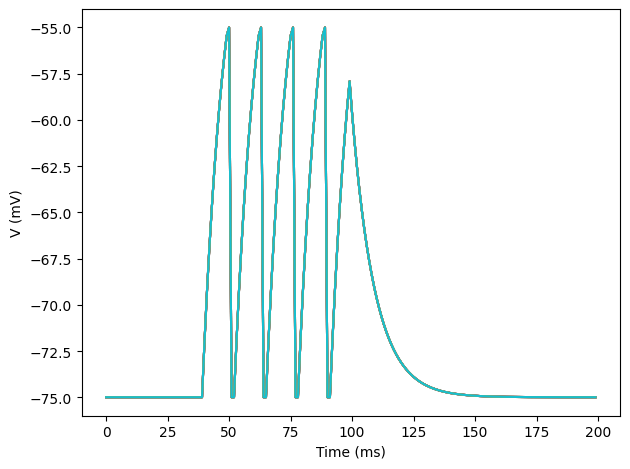

In [10]:
plot_voltage(volt_mem, steps)

In [11]:
spikes = [output[i].get('spiked') for i in range(steps)]
spikes = torch.stack(spikes)
spikes.shape

torch.Size([200, 10])

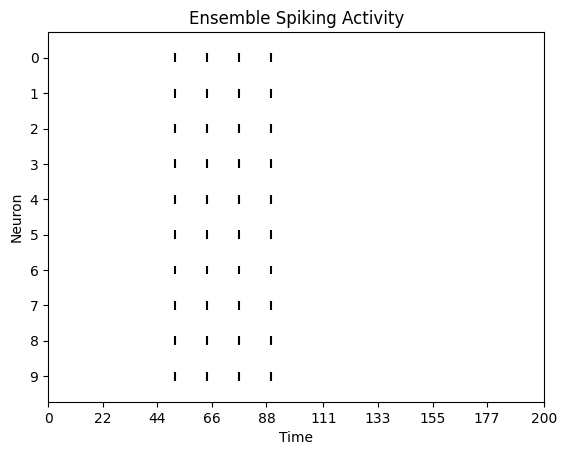

In [12]:
spike_raster(spikes)

## Now let's customize the synapses and synaptic weights in that ensemble

In [13]:
from sapinet.synapse import Synapse

We define a `SingleEnsemble` class that contains a `LIFEnsemble` of 10 neurons and we customize the synaptic connection matrix and synaptic weight matrix of this ensemble. In this case the synaptic connections are static and do not change with time.

In [14]:
steps = 200

In [15]:
I = torch.ones(steps) * 200
I[int(steps/2):] = 0
I[:int(steps/5)] = 0

In [16]:
class SingleEnsemble(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.simulation_step = 0

        #Define the LIF Ensemble object
        self.ensemble = LIFEnsemble(num_units=10, leak_gl=5, tau_mem=5, tau_ref=1)
        # Define the Synapse object
        self.synapse = Synapse(src_ensemble=self.ensemble, dst_ensemble=self.ensemble,
                                 weight_min=0, weight_max=100)
        # Customise connections with randomly generated connections between neurons
        self.synapse.connections = torch.randint(0, 2, (10, 10))
        # Customize synaptic weights with randomly generated weights
        self.synapse.weights = torch.rand(10, 10) * 100
        
    def forward(self, x: torch.Tensor):
        # after the first iteration, the input to the ensemble must include the incoming synapses' output as well.
        synapse_output = self.synapse(self.ensemble.spiked.float())
        ensemble_output = self.ensemble(x + (self.synapse.output if self.simulation_step > 0 else 0))
        self.simulation_step += 1
        return ensemble_output, synapse_output

single_ensemble = SingleEnsemble()

We plot the connectivity matrix

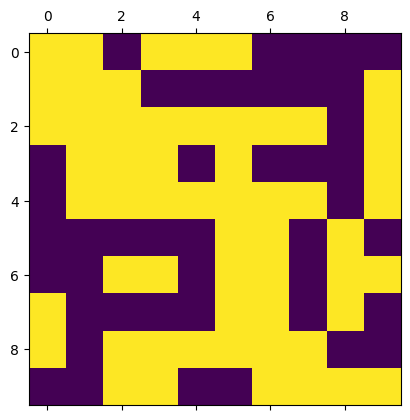

In [17]:
plt.matshow(single_ensemble.synapse.connections)

And the weight matrix

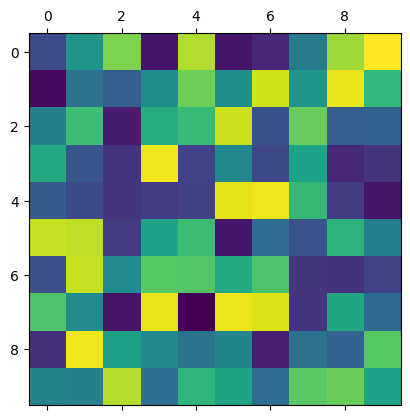

In [18]:
plt.matshow(single_ensemble.synapse.weights)

In [19]:
output2 = [single_ensemble.forward(I[i]) for i in range(steps)]
print(output2[0])

({'volt_mem': tensor([-75., -75., -75., -75., -75., -75., -75., -75., -75., -75.]), 'spiked': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32), 'input': tensor([0.])}, {'weights': tensor([[23.3693, 51.7809,  0.0000,  6.3497, 86.7586,  6.3257,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 3.1531, 38.1224, 30.7739,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, 65.4703],
        [43.5219, 68.2855,  8.4448, 61.6577, 66.5219, 91.0732, 25.2414, 75.7353,
          0.0000, 31.4789],
        [ 0.0000, 26.7309, 15.7220, 96.4008,  0.0000, 46.6013,  0.0000,  0.0000,
          0.0000, 15.5374],
        [ 0.0000, 22.7134, 15.4248, 17.5938, 19.5704, 94.6286, 95.9886, 65.7344,
          0.0000,  6.1634],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.8122, 35.7061,  0.0000,
         63.7607,  0.0000],
        [ 0.0000,  0.0000, 48.3583, 73.3553,  0.0000, 60.4690, 71.0223,  0.0000,
         14.9180, 20.5623],
        [71.1871,  0.0000,  0.0000,  0.0000,  0.

In [20]:
volt_mem2 = [output2[i][0].get('volt_mem') for i in range(steps)]
volt_mem2 = torch.stack(volt_mem2)
volt_mem2.shape

torch.Size([200, 10])

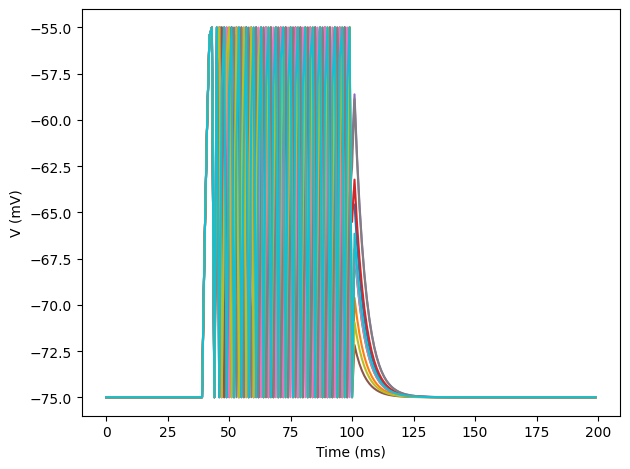

In [21]:
plot_voltage(volt_mem2, steps)

In [22]:
spikes2 = [output2[i][0].get('spiked') for i in range(steps)]
spikes2 = torch.stack(spikes2)
spikes2.shape

torch.Size([200, 10])

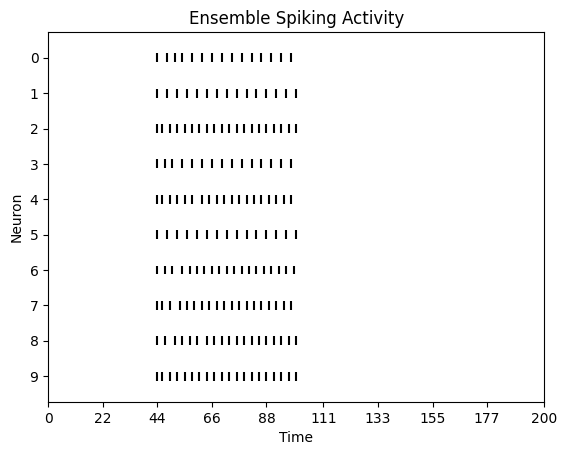

In [23]:
spike_raster(spikes2)